In [1]:
%cd ..
%ls

/home/mahdigilany/offline_codes/codes/ts_snr
configs/     main.py     original_deeptime/  scripts/     wandb/
darts_logs/  notebooks/  README.md           slurm_logs/
logs/        OLD/        requirements.txt    src/


In [5]:
import os
from glob import glob
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.datasets import AirPassengersDataset

import pprint
from einops import rearrange, repeat, reduce
from darts.timeseries import concatenate

In [6]:
i_th_run = 0
exp_name = f"deeptime_etth2_in672_out96_noise_std0_vbaseline_target_last_no_valintest_seed0"
main_dir = f"logs/experiments/runs/{exp_name}"
main_dir = os.path.join(os.getcwd(), main_dir)
work_dir = glob(os.path.join(main_dir, "**/darts_logs"), recursive=True)
config_dir = glob(os.path.join(main_dir, "**/config.yaml"), recursive=True)
config_dir = [dir for dir in config_dir if "wandb" not in dir]
work_dir = work_dir[i_th_run]
config_dir = config_dir[i_th_run]
config_dir

'/home/mahdigilany/offline_codes/codes/ts_snr/logs/experiments/runs/deeptime_etth2_in672_out96_noise_std0_vbaseline_target_last_no_valintest_seed0/2023-07-12_13-51-39/config.yaml'

In [12]:
from omegaconf import OmegaConf
from src.driver.drivers import inference_darts_lightning_driver_run
from darts.models.forecasting.torch_forecasting_model import TorchForecastingModel

config = OmegaConf.load(config_dir)
config.logger = None
model: TorchForecastingModel
model, data, metrics = inference_darts_lightning_driver_run(config)

Using component OT as target series.


/home/mahdigilany/anaconda3/envs/borealis/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [13]:
# Dict config to dict
config2 = OmegaConf.to_container(config, resolve=True)
pprint.pprint(config2)

{'_recursive_': False,
 'batch_size': 256,
 'callbacks': {'early_stopping': {'_target_': 'pytorch_lightning.callbacks.EarlyStopping',
                                  'mode': 'min',
                                  'monitor': 'val_loss',
                                  'patience': 10}},
 'data': {'_target_': 'src.data.registry.data_registry.create_noisy_dataset',
          'dataset_name': 'etth2',
          'noise_mean': 0,
          'noise_std': 0,
          'target_series_index': -1,
          'use_scaler': True},
 'driver': {'_target_': 'hydra.utils.get_method',
            'path': 'src.driver.drivers.darts_globalforecasting_driver_run'},
 'epochs': 100,
 'id': 1299520,
 'logger': None,
 'model': {'_target_': 'src.modeling.registry.ts_model_registry.create_model',
           'batch_size': 256,
           'input_chunk_length': 672,
           'lr_scheduler_cls': {'_target_': 'hydra.utils.get_class',
                                'path': 'src.modeling.registry.optimizer_schedule

In [14]:
train, val, test, scaler = data.train_series, data.val_series, data.test_series, data.scaler
# model.load_weights_from_checkpoint(config.model.model_name, work_dir=work_dir) # don't use load_from_checkpoint since needs logger and produces error

## manual prediction using manual test loader

### manual load

In [15]:
from darts.models.forecasting.torch_forecasting_model import _get_checkpoint_folder, _get_checkpoint_fname

model_name = config.model.model_name

file_name = _get_checkpoint_fname(work_dir, model_name, best=True)
if file_name[:5] == "last-" or file_name[:5] == "best-":
    checkpoint_dir = _get_checkpoint_folder(work_dir, model_name)
    
ckpt_path = os.path.join(checkpoint_dir, file_name)
ckpt = torch.load(ckpt_path)
ckpt_hyper_params = ckpt["hyper_parameters"]

mock_train_sample = [
    np.zeros(sample_shape) if sample_shape else None
    for sample_shape in ckpt["train_sample_shape"]
]
model.train_sample = tuple(mock_train_sample)
model.model = model._init_model()
model.model.to_dtype(ckpt["model_dtype"])
model.model.load_state_dict(ckpt["state_dict"], strict=True)
model._fit_called = True

### manual prediction

In [16]:
from darts.timeseries import concatenate 
from darts.utils.data.sequential_dataset import PastCovariatesSequentialDataset


horizon = 96
lookback = 672
# val_test_series_trimmed = concatenate([val[-lookback:], test])
val_test_series_trimmed = concatenate([test])
# test_ds = model._build_train_dataset(val_test_series_trimmed, past_covariates=None, future_covariates=None, max_samples_per_ts=None)
test_ds = PastCovariatesSequentialDataset(val_test_series_trimmed, input_chunk_length=lookback, output_chunk_length=horizon, covariates=None, use_static_covariates=False)
from torch.utils.data import DataLoader
from tqdm import tqdm
test_dl = DataLoader(
    test_ds,
    batch_size=model.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    drop_last=False,
    collate_fn=model._batch_collate_fn,
    )

pl_model = model.model 
pl_model.eval()
preds = []
targets = []
for batch in tqdm(test_dl, desc="evaluating on test set"):
    input_series, _, _, target_series = batch
    input_series = input_series.to(device=pl_model.device, dtype=pl_model.dtype)
    target_series = target_series.to(device=pl_model.device, dtype=pl_model.dtype)
    pred = pl_model((input_series, _))
    preds.append(pred.detach().cpu())
    targets.append(target_series.detach().cpu())
preds = torch.cat(preds, dim=0)
targets = torch.cat(targets, dim=0)

preds = preds.flip(dims=[0])
targets = targets.flip(dims=[0])

# turn into TimeSeries
list_backtest_series = []
for i in range(preds.shape[0]):
    backtest_series = TimeSeries.from_times_and_values(
        val_test_series_trimmed.time_index[lookback+i:lookback+i+horizon],
        preds[i,...].detach().cpu().numpy(),
        freq=val_test_series_trimmed.freq
        )
    list_backtest_series.append(backtest_series)

evaluating on test set: 100%|██████████| 11/11 [00:01<00:00,  5.77it/s]


In [17]:
list_backtest_series[0]
preds[0, 0, ...]
# targets[0,-1,...]

tensor([[-0.7605]], dtype=torch.float64)

### calculate metrics

In [18]:
from src.utils.metrics import calculate_metrics
results = calculate_metrics(
    [test]*len(list_backtest_series),
    list_backtest_series,
    reduction=np.array,
    verbose=True,
    n_jobs=-1,
    only_mse=True,
    )     
results = {
    result_name: np.vstack(results[result_name])
    for result_name in results.keys()
    if not np.isnan(np.array(results[result_name])).any()
    }

  0%|          | 0/2718 [00:00<?, ?it/s]

In [20]:
results['mse'].mean()

0.244567587100613

### validate prediction and targets

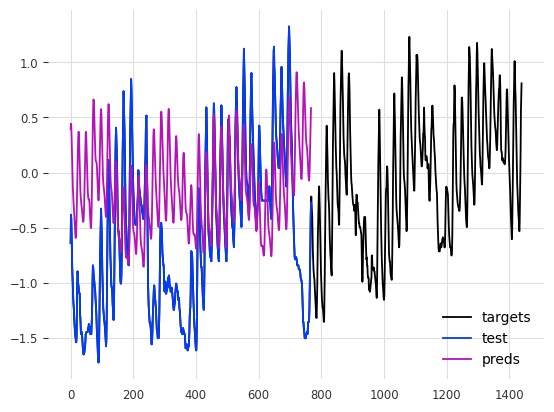

In [21]:
component = 0
n = 96*15
which_th = 95
plt.plot(range(len(targets[:n,which_th,component])), targets[:n,which_th,component], label="targets")
# plt.plot(range(len(targets[-n:,which_th+1,component])), targets[-n:,which_th+5,component], label="targets")
plt.plot(range(len(test._xa.values[lookback:n,component,0])), test._xa.values[which_th+lookback:n+which_th,component,0], label="test")
plt.plot(range(len(preds[lookback:n,which_th,component,0])), preds[lookback:n,which_th,component,0], label="preds")
plt.legend()

## Working on new idea

### get internal states of model

#### get representation f_L and f_H

In [228]:
lookback_len = config.model.input_chunk_length
tgt_horizon_len = config.model.output_chunk_length
batch_size = config.model.batch_size

pl_model = model.model
pl_model.eval()

coords = pl_model.get_coords(lookback_len, tgt_horizon_len)
time_reprs = repeat(pl_model.inr(coords), '1 t d -> b t d', b=batch_size).to(device=pl_model.device, dtype=pl_model.dtype)
print(time_reprs.shape)

f_L = time_reprs[:, :-tgt_horizon_len, :]
f_H = time_reprs[:, -tgt_horizon_len:, :]

ones = torch.ones(batch_size, f_L.shape[1], 1, device=f_L.device)
f_L = torch.concat([f_L, ones], dim=-1)
ones = torch.ones(batch_size, f_H.shape[1], 1, device=f_H.device)
f_H = torch.concat([f_H, ones], dim=-1)
print(f_L.shape, f_H.shape)

import torch.nn.functional as F
reg_coeff = F.softplus(pl_model.adaptive_weights._lambda)
reg_coeff

torch.Size([256, 768, 256])
torch.Size([256, 672, 257]) torch.Size([256, 96, 257])


tensor(78.5169, dtype=torch.float64, grad_fn=<SoftplusBackward0>)

#### get w_L and W corresponding to (f_LTf_L)^-1f_LT and f_H(f_HTf_H)^-1

In [229]:
reprsTreprs = (f_L.permute(0, 2, 1) @ f_L)
reprsTreprs.diagonal(dim1=-2, dim2=-1).add_(reg_coeff)
w_L = torch.inverse(reprsTreprs) @ f_L.permute(0, 2, 1)
W = f_H @ w_L 
w_L.shape, W.shape

(torch.Size([256, 257, 672]), torch.Size([256, 96, 672]))

#### test to see if everything is correct

In [235]:
iterative_test_loader = iter(test_dl)
_input, _, _, _target  = next(iterative_test_loader)
_input = _input.to(device=pl_model.device, dtype=pl_model.dtype)
_target = _target.to(device=pl_model.device, dtype=pl_model.dtype)
# (w_L @ _input)[0,:10,0], pl_model.adaptive_weights(f_L, _input)[0,:10,0]
_pred = W @ _input

In [236]:
_pred[0,:5].squeeze(), preds[-1,:5].squeeze() # make sure the prediction is correct

(tensor([-0.1941, -0.1812, -0.1236, -0.0571,  0.0101], dtype=torch.float64,
        grad_fn=<SqueezeBackward0>),
 tensor([-0.1941, -0.1812, -0.1236, -0.0571,  0.0101], dtype=torch.float64))

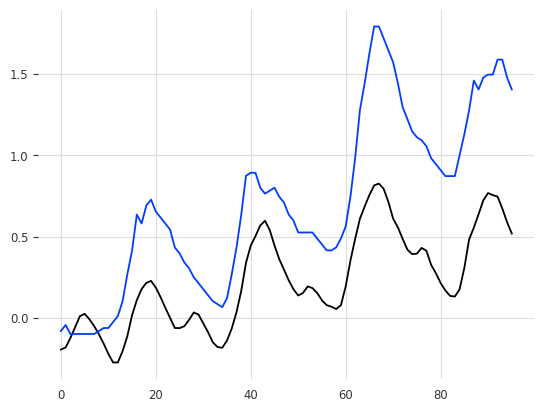

In [227]:
%matplotlib inline
plt.plot(range(96),_pred[0,...].detach().cpu().numpy().squeeze())
plt.plot(range(96),_target[0,...].detach().cpu().numpy().squeeze())

#### find residuals

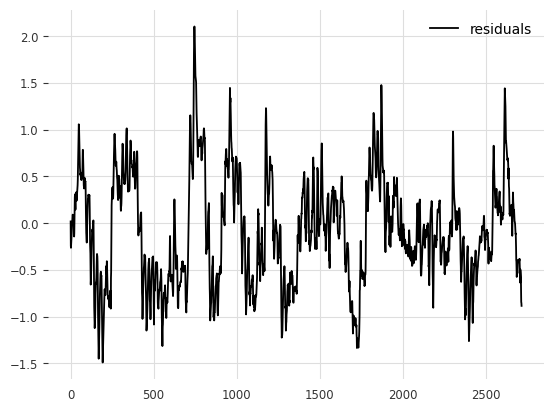

In [254]:
res = preds.squeeze(-1) - targets

component = 0
n = 96*256
which_th = 95
plt.plot(range(len(res[:n,which_th,component])), res[:n,which_th,component], label="residuals")
# plt.plot(range(len(targets[-n:,which_th+1,component])), targets[-n:,which_th+5,component], label="targets")
# plt.plot(range(len(test._xa.values[lookback:n,component,0])), test._xa.values[which_th+lookback:n+which_th,component,0], label="test")
# plt.plot(range(len(preds[lookback:n,which_th,component,0])), preds[lookback:n,which_th,component,0], label="preds")
plt.legend()
# _target.shape, W.shape, _input.shape
# torch.linalg.solve(_input.permute(0,2,1), _target.permute(0,2,1)).shape

### plot basis in 3d

<IPython.core.display.Javascript object>

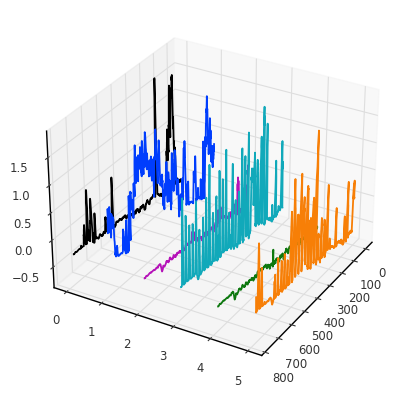

In [117]:
# for interactive 3d plot (not working)
from importlib import reload
reload(plt)
%matplotlib notebook

time_reprs_numpy = time_reprs.detach().cpu().numpy()
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(30, 30)
X, Y = np.meshgrid(range(len(time_reprs_numpy[0,0,:])), range(len(time_reprs_numpy[0,:,0])))
for i in range(time_reprs_numpy.shape[2]):
    if i>5:
        break
    ax.plot3D(Y[:,0], X[:,i], time_reprs_numpy[0,:,i])
fig
# X, Y = np.meshgrid(range(len(time_reprs_numpy[0,0,:])), range(len(time_reprs_numpy[0,:,0])))
# ax.plot_surface(X, Y, time_reprs_numpy[0,...], rstride=1, cstride=1, cmap='viridis', edgecolor='none')

# plt.plot(range(len(time_reprs_numpy[0,:,:])), time_reprs_numpy[0,:,:], label="time_reprs")
# plt.figure()
# plt.plot(concatenate([train, val, test])._xa.values.squeeze())

## historical forecast instead on manual test loader

In [14]:
from darts.timeseries import concatenate 
train_val_series_trimmed = concatenate([train, val])[-max(len(test), config.model.input_chunk_length):] # TODO: this is not a good way to do it
train_val_test_series_trimmed = concatenate([train_val_series_trimmed[-config.model.input_chunk_length:], test])

In [15]:
train_val_test_series_trimmed.time_index[671], test.time_index[0], test.start_time()

(Timestamp('2018-02-01 14:00:00', freq='H'),
 Timestamp('2018-02-01 15:00:00', freq='H'),
 Timestamp('2018-02-01 15:00:00', freq='H'))

### historical_forecasts on values close to validation

In [ ]:
n = 100
backtest_series = model.historical_forecasts(
    train_val_test_series_trimmed[:config.model.input_chunk_length+config.model.output_chunk_length+n],
    start=test.start_time(),
    forecast_horizon=config.model.output_chunk_length,
    retrain=False,
    verbose=True,
    # stride=stride, #default 1
    last_points_only=False, #default True 
    )

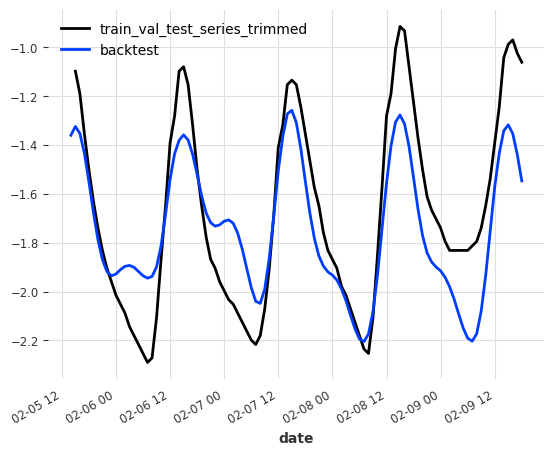

In [33]:
list_lasts_backtest = [backtest[-1] for backtest in backtest_series]
list_lasts_backtest = concatenate(list_lasts_backtest)
train_val_test_series_trimmed[config.model.input_chunk_length+config.model.output_chunk_length:config.model.input_chunk_length+config.model.output_chunk_length+n].plot(label="train_val_test_series_trimmed")
list_lasts_backtest.plot(label="backtest")

### historical_forecasts on values far from validation

In [ ]:
n = 1000
backtest_series = model.historical_forecasts(
    train_val_test_series_trimmed[-(config.model.input_chunk_length+config.model.output_chunk_length+n):],
    start=test[-(config.model.input_chunk_length+config.model.output_chunk_length+n):].start_time(),
    forecast_horizon=config.model.output_chunk_length,
    retrain=False,
    verbose=True,
    # stride=stride, #default 1
    last_points_only=False, #default True 
    )

#### a couple of predicted series in between

2018-05-20 03:00:00 2018-05-20 02:00:00


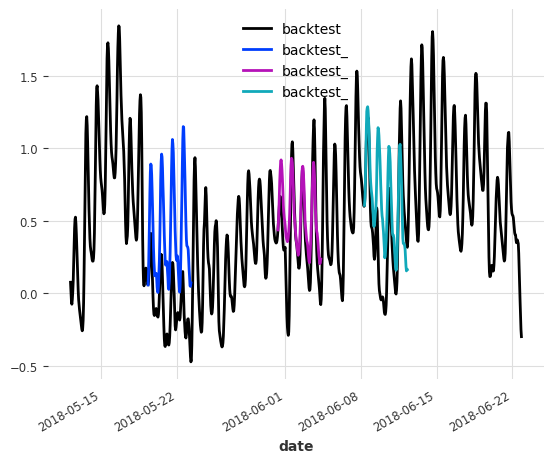

In [75]:
list_lasts_backtest = [backtest[0] for backtest in backtest_series]
list_lasts_backtest = concatenate(list_lasts_backtest)
# train_val_test_series_trimmed[-n:].plot(label="train_val_test_series_trimmed")
list_lasts_backtest.plot(label="backtest")
print(backtest_series[191].time_index[0], train_val_test_series_trimmed[-n-1:].time_index[95])
backtest_series[96*2-20].plot(label="backtest_")
backtest_series[96*5-20].plot(label="backtest_")
backtest_series[96*7-20].plot(label="backtest_")
 

#### only first values of predicted series plotted

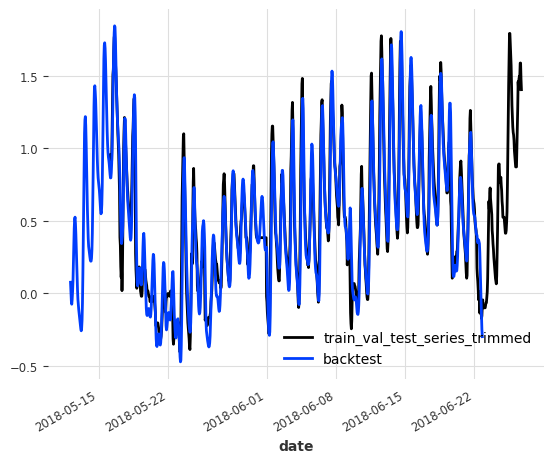

In [112]:
list_lasts_backtest = [backtest[0] for backtest in backtest_series]
list_lasts_backtest = concatenate(list_lasts_backtest)
train_val_test_series_trimmed[-n:].plot(label="train_val_test_series_trimmed")
list_lasts_backtest.plot(label="backtest")


In [113]:
train_val_test_series_trimmed[-96].time_index, list_lasts_backtest.time_index[-1]

(DatetimeIndex(['2018-06-22 20:00:00'], dtype='datetime64[ns]', name='date', freq='H'),
 Timestamp('2018-06-22 20:00:00', freq='H'))

#### last values of predicted series plotted

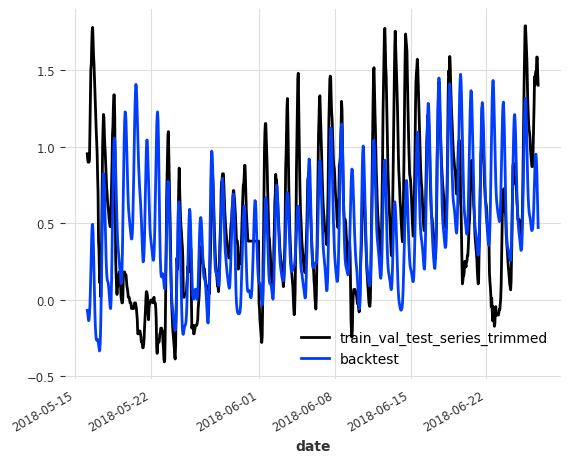

In [114]:
list_lasts_backtest = [backtest[-1] for backtest in backtest_series]
list_lasts_backtest = concatenate(list_lasts_backtest)
train_val_test_series_trimmed[-n:].plot(label="train_val_test_series_trimmed")
list_lasts_backtest.plot(label="backtest")


In [115]:
train_val_test_series_trimmed[-n:].time_index[0], list_lasts_backtest.time_index[0]

(Timestamp('2018-05-16 03:00:00', freq='H'),
 Timestamp('2018-05-16 03:00:00', freq='H'))

### test is our dataloader prediction matches the historical forecasting predictions

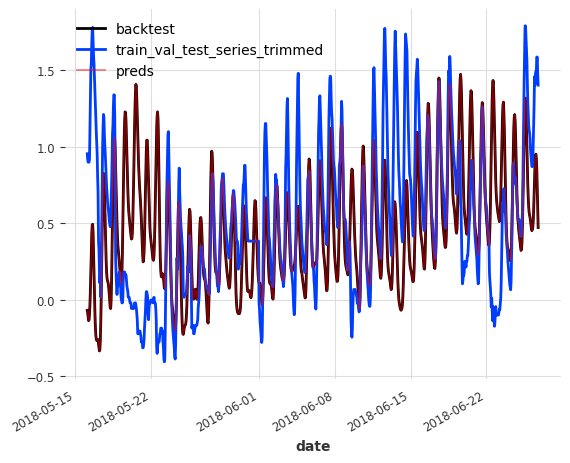

In [129]:
component = 0
n = 1001
which_th = 95
list_lasts_backtest = [backtest[which_th] for backtest in backtest_series]
list_lasts_backtest = concatenate(list_lasts_backtest)
list_lasts_backtest.plot(label="backtest")
train_val_test_series_trimmed[-n:].plot(label="train_val_test_series_trimmed")
plt.plot(list_lasts_backtest.time_index, preds[-n:,which_th,component,0], label="preds", color="red", alpha=0.5)
plt.legend()

### calculate metrics

In [ ]:
from src.utils.metrics import calculate_metrics
results = calculate_metrics(
    [train_val_test_series_trimmed[-n:]]*len(backtest_series),
    backtest_series,
    reduction=np.array,
    verbose=True,
    n_jobs=-1
    )    

In [138]:
np.array(results['mse']).mean(), np.array(results['mae']).mean(), np.array(results['mape']).mean(), np.array(results['smape']).mean(), np.array(results['rmse']).mean(), np.array(results['r2']).mean()

(0.21046891858121383,
 0.33896728912112273,
 503.26643956101253,
 85.7308304101625,
 0.4016309768361865,
 -inf)

### cross correlation FAILED

In [221]:
from darts.utils.statistics import plot_acf, check_seasonality
from statsmodels.tsa.stattools import acf, ccf
series_no = 95
target = train_val_test_series_trimmed[-n:]._xa.values
target_backtest = targets[-n:,:,0]

sum_array = np.zeros(len(target))
for i in range(len(train_val_test_series_trimmed[-n:])-95):
    series_no = 95 + i
    # cross_correlation = ccf(backtest_series[series_no]._xa.values, target, adjusted=False, fft=False)
    cross_correlation = ccf(target_backtest[series_no,:], target, adjusted=False, fft=False)
    cross_correlation = cross_correlation[i:] # remove the first i values
    sum_array[:len(cross_correlation)] += cross_correlation
   
    
    

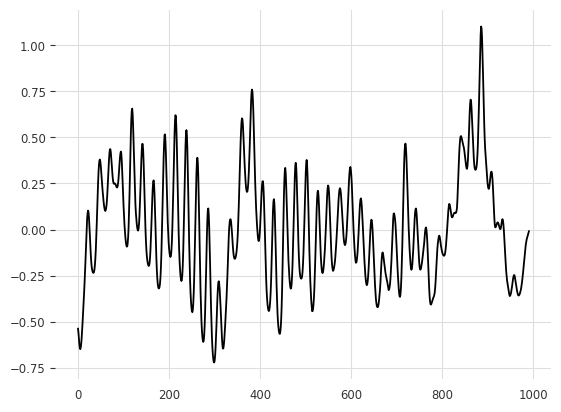

In [224]:
i = 10
series_no = 95 + i
cc = ccf(target_backtest[series_no,:], target, adjusted=False, fft=False)
plt.plot(cc[i:])

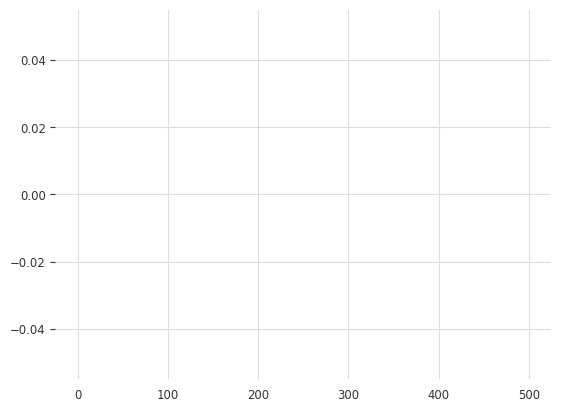

In [219]:
m=96*1
nlags=500
for i in range(len(sum_array)):
    if i>nlags:
        break
    plt.plot(
        (i, i),
        (0, sum_array[i]),
        color=("#b512b8" if m is not None and i == m else "black")
        if True
        else None,
        lw=(1 if m is not None and i == m else 0.5),
    )

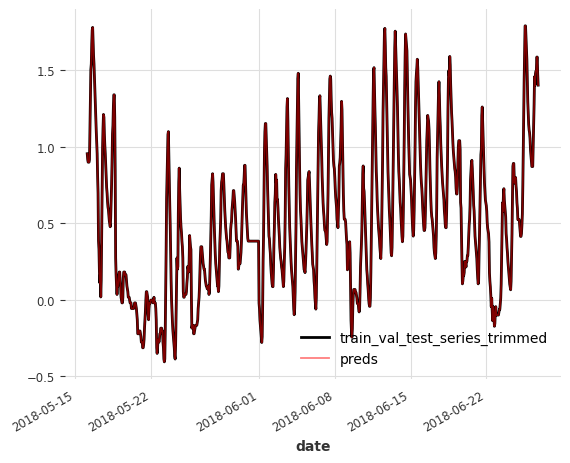

In [194]:
targets[-1001:].shape
component = 0
n = 1001
which_th = 95

train_val_test_series_trimmed[-n:].plot(label="train_val_test_series_trimmed")
plt.plot(train_val_test_series_trimmed[-n:].time_index, targets[-n:,which_th,component], label="preds", color="red", alpha=0.5)
plt.legend()